### Univariate linear regression

In this part, we'll introduce you to the main library that we'll use in this course: `PyTorch` by Facebook. We'll focus on a very basic network architecture, that of "linear regression".

#### PyTorch

In this notebook, we revisit some of the basic network architectures that we already covered in the previous slides, but this time using actual code, which will make everything more concrete. The library that we will use throughout this course is the well-known and extremely accessible `PyTorch` library. This package's [website](https://pytorch.org) is a great resource and it comes packed with nice tutorials.

We previously used `keras`+`tensorflow`. Why [PyTorch](https://www.simplilearn.com/keras-vs-tensorflow-vs-pytorch-article)? It is often used by engineers and scientists in natural language processing, because it offers a very intuitive,  "Pythonesque" interface, especially for recurrent neural networks (RNNs) and Transformers (which we'll cover in our last session and NLP course). It is easier to use than `tensorflow`, but it is a slightly more low-level library than `keras`. To sum up, `PyTorch` offers a great balance between speed, simplicity and flexibility. You will see that `PyTorch` allows you to implement and train complex models in a simple way.

#### Alternatives

`Keras` (you can find it [here](https://keras.io)) has been a real "game changer", when it comes to the popularity and democratization of deep learning. Conceptually, `keras` is "only" a higher-level **framework** or "wrapper" around a so-called **backend**, namely `tensorflow`. This is a low-level library that has been developed by Google and which implements most of the actual computation being done. You can check out Tensorflow's [website](https://www.tensorflow.org/), but we should stress that working with tensorflow has a  steep learning curve, because it requires much higher-level coding skills and deeper insights into the workings of neural network.


We'll start by importing the relevant libraries (most of which you'll know by now):

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# # %cd gdrive/MyDrive/ML2022/session-1
# %cd gdrive/MyDrive/my_ml_2023/session-6

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random
import utils

# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)


### California housing dataset

In this session, we'll start with a common task in machine learning, namely  the prediction of house prices. You can easily obtain a dataset from sklearn (that makes it easy to download the dataset, as you'll notice when you run the block below). Let's load it:

In [5]:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True)

This dataset was obtained from the StatLib repository. https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

An household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surpinsingly large values for block groups with few households and many empty houses, such as vacation resorts.




In [6]:
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Now, we must divide our data into multiple, fixed parts that are known as **splits**. Typically these splits include three **standardized sets** (that shouldn't overlap with one another):
- a **training** set (using for optimizing the network)
- a **val(idation)** or **dev(elopment)** set (used to monitor how well the training is going)
- a **test** set (used to see how well the network performs after training is done; if you want to compare several models you have to use  **the same test set** for each model)

You can do with the training and development sets whatever you want, but, ideally, the test set is used **only once** (i.e. when you are ready to test your model, and not earlier). Repeated testing on the test is considered bad practice ("cheating") and you have to be careful with that. Development sets have become much more prominent in recent years: they were used less in conventional machine learning, where **cross-validation** was the prefered evaluation procedure (e.g. 10-CV, leave-one-out, ...). Because deep learning is so computationally expensive and datasets have grown prohibitively large, cross-validation is somewhat less commonly used nowadays, and people stick to a (single!) train/dev/test setup.

Standardized splits are important for monitoring progress in machine learning, ensuring that all people reporting the performance of their system on this dataset do so in the same **experimental conditions**. These sets are typically created randomly, so it's easier to image that some shuffles of the data (accidentally?) lead to an "easier" version (where the test for instance doesn't include very difficult cases).

Often the training dataset will be larger than the dev and test set (which are often equal in size). A typical distribution might be 80%-10%-10% (but sometimes people have a reason to deviate from that, e.g. if a dataset is really small, and adopt a 50%-25%-25% or very big, then test/dev sets are much smaller). Also, as you know, it's important to properly **stratify** your data, ensuring, for instance, that the distribution of target values (or class labels) is similar across the three sets. There are many other variables that you can take into account when creating these splits and it's important that you take proper care of this step (also for your exam project!).

Back to our dataset, we will split it using a function from sklearn. First, we separate our target variable MedHouseVal ("y") from the input features ("X"). Second, we apply the train_test_split function to split our data into 3 splits.


In [7]:
from sklearn.model_selection import train_test_split

X, y = california_housing.frame.drop(['MedHouseVal'], axis=1), california_housing.frame['MedHouseVal']

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, test_size=0.5, random_state=42)



As we said in the slides, deep learning is all about playing with blocks, so it's important that you understand the **shape** of your data:

In [8]:
print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)

print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(16512, 8)
(2064, 8)
(2064, 8)
(16512,)
(2064,)
(2064,)


Have a look at these numbers: the input has the form of a matrix (two dimensions), the output has the form of a vector (one dimension). The training set contains information of 16512 individual block groups, whereas the test/dev set contains information on 2064 blocks. The output has a single number for each block group, which is the median house value. We can plot a KDE density plot to check what the median house value looks like in both datasets:

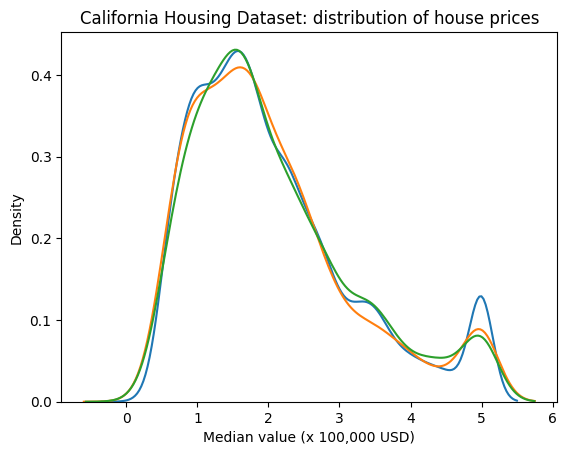

In [9]:
ax = sns.kdeplot(y_train, label='train')
sns.kdeplot(y_dev, ax=ax, label='dev');
sns.kdeplot(y_test, ax=ax, label='test');
plt.title('California Housing Dataset: distribution of house prices')
plt.ylabel('Density');
plt.xlabel('Median value (x 100,000 USD)');

You can see that the data is well stratified because the distribution of house prices is reasonably similar in all sets.

Evidently, the number of "rows" or instances is the same as with the y's, but the x's have a second dimension corresponding to 8 columns. For each block group, the dataset records 8 features that could potentially have an effect on the median house price in that area:

|n | variable|description|
|:-:|:-:|:----:|
|0|MedInc |    median income in block group|
|1| HouseAge|    median house age in block group|
|2|AveRooms |   average number of rooms per household|
|3|AveBedrms  |   average number of bedrooms per household|
|4|Population  |   block group population|
|5|AveOccup   |   average number of household members|
|6|Latitude  |     block group latitude|
|7|Longitude  |    block group longitude|



To make the selection of specific columns from this data easier, we'll keep track of the column names in a list:

In [10]:
feature_names = california_housing.frame.columns[:-1]
print(feature_names)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


### Scaling

Is a distance measured in meters more important than a distance measured in miles? No, they describe the same distance but at different scales. The model might estimate that the distance of 1000 meters is 1000 times more important than the distance of 1 kilometer, but if we scale these distances into the same range (for example, from 0 to 1), the model will understand that these units are the same.

#### Distance-based methods (like KNN and SVM)
In real life, we usualy don't have these situations when models compare meters and miles. Usually, we use distances between data points to calculate their similarity. If we are comparing dogs and cats, we can use their weight and height. Let's say the difference between a dog and a cat is 1 kilo and 10 centimetres. The higher the absolute difference (1 kilo vs 10 centimetres), the more influential this features might be for the model. We would like to avoid this bias towards big differences, and that's why we apply scaling. So that all the features contribute equally to the result. Feature scaling are method used to normalize the range (for example, from -1 to 1) features of data.

####  Gradient Descent Based Algorithms

If a model uses gradient descent, then the difference in ranges of features will cause different step sizes for each feature. The feature scaling is beneficial because it makes sure that the steps for gradient descent are updated at the same rate for all the features:

1.   Quicker converge towards the optimization minimum.
2.   It prevents the optimization from getting stuck in local minimum and jumping over minimum for some features.

In regression tasks (not classification), the target variable should also be scaled (normalized).


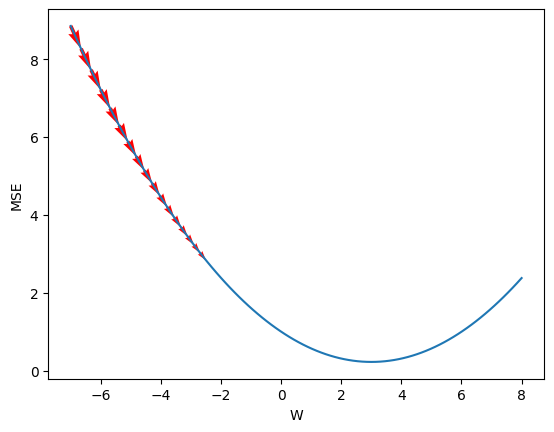

In [11]:
utils.plot_grad_descent(0.2, n_updates=17, x_scale=0.5)

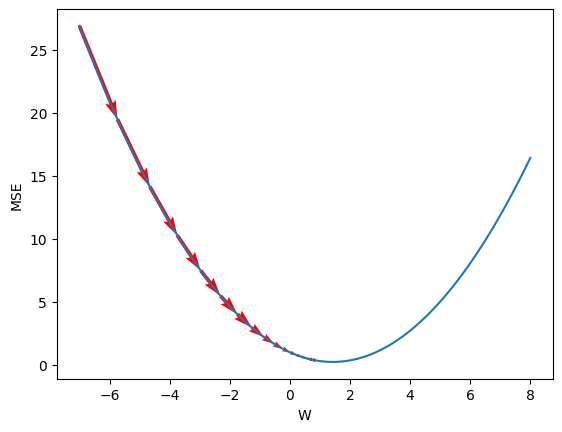

In [12]:
utils.plot_grad_descent(0.2, n_updates=17, x_scale=1)

Our data before the scaling looks like:

In [13]:
x_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.880754,28.608285,5.435235,1.096685,1426.453004,3.096961,35.643149,-119.582290
std,1.904294,12.602499,2.387375,0.433215,1137.056380,11.578744,2.136665,2.005654
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000
25%,2.566700,18.000000,4.452055,1.006508,789.000000,2.428799,33.930000,-121.810000
50%,3.545800,29.000000,5.235874,1.049286,1167.000000,2.817240,34.260000,-118.510000
75%,4.773175,37.000000,6.061037,1.100348,1726.000000,3.280000,37.720000,-118.010000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000


In [14]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train.values)
x_dev = x_scaler.transform(x_dev.values)
x_test = x_scaler.transform(x_test.values)

After scaling:

In [15]:
pd.DataFrame(x_train, columns=feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-6.519333e-17,-9.251859e-18,-1.981081e-16,-1.707291e-16,-2.151595e-19,4.936566e-17,6.400995e-17,1.753335e-15
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-1.775438e+00,-2.190766e+00,-1.904386e+00,-1.762117e+00,-1.251913e+00,-2.076846e-01,-1.447697e+00,-2.377207e+00
25%,-6.900689e-01,-8.417859e-01,-4.118373e-01,-2.081645e-01,-5.606339e-01,-5.770769e-02,-8.018107e-01,-1.110749e+00
50%,-1.758995e-01,3.108328e-02,-8.350905e-02,-1.094160e-01,-2.281865e-01,-2.415892e-02,-6.473597e-01,5.346501e-01
75%,4.686502e-01,6.658972e-01,2.621376e-01,8.455177e-03,2.634487e-01,1.580865e-02,9.720351e-01,7.839530e-01
max,5.839268e+00,1.856173e+00,5.716655e+01,5.664727e+01,3.012743e+01,1.071164e+02,2.951816e+00,2.628794e+00


In [16]:
y_scaler = StandardScaler()

"""
we add a new dimension to y's (it had just one) to fulfil requirements of
StandardScaler (2 dimensions)
"""

y_train = np.expand_dims(y_train.values, axis=1)
y_dev = np.expand_dims(y_dev.values, axis=1)

y_train = y_scaler.fit_transform(y_train)
y_dev = y_scaler.transform(y_dev)

Finally, we'll make sure that our data has the right (numeric) format. Here, we change our the specific data type to `torch.float` tensors (matrices with ore dimensions) to feed it later to our model:

In [17]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_dev = torch.tensor(x_dev, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)

y_train = torch.tensor(y_train, dtype=torch.float)
y_dev = torch.tensor(y_dev, dtype=torch.float)


Note that this is a simple operation, that only changes the types, but not the shape of our variables:

In [18]:
print(x_train.shape, x_train.dtype)
print(x_test.shape, x_train.dtype)

print(y_train.shape, x_train.dtype)
print(y_test.shape, x_train.dtype)

torch.Size([16512, 8]) torch.float32
torch.Size([2064, 8]) torch.float32
torch.Size([16512, 1]) torch.float32
(2064,) torch.float32


### Linear functions
(*Recap from bootcamp*)

Remember: all machine learning models are, mathematically speaking, **functions**; they all essentially boil to the expression $f(x) = \hat{y}$. This means that they try to predict $\hat{y}$ on the basis of $x$, assuming that $y$ can be modelled as a "function" of $x$. In this session, we'll cover two very simple neural network architectures to implement two very general, predictive models (that are certainly not specific to neural networks):

- univariate linear regression: predict a single number, on the basis of another number
- multivariate linear regression: predict a single number, on the basis of 2 or more other numbers (see the next notebook)

We specifically speak of **regression** in this context (as opposed to **classification**), because our output variable is a (single) floating scalar. Obviously, what we'll try to predict for the California Housing dataset is the median price of houses in one of the dataset's block group. Additionally, we call these models **linear**: why is that? In data modelling, special significance is attached to linear functions. Algebraically, these functions take input variables ($x_0, x_1, x_2 ... $) which get multiplied by some **coefficients** and (finally) summed, and added to a **bias** (constant) to calculate their output. Each input variable gets associated with exactly one coefficient. Additionaly, there's exactly one bias parameter in the linear model (because there's only one output variable in this basic model).

> Such linear models are distinguished from higher-order models (such as "polynomials"), because no "higher powers" are involved the function's calculation. (More precise would be to say the the input parameters are taken to the power of one (and only to the power of one), instead of including e.g. squares of the input data.)

Below, we'll first look at a simple univariate network; from there we'll take it to multivariate networks in the next notebook. Although these might look like very different models, you should notice how little changes in terms of math and code. Mathematically:

##### Univariate linear function

If the function only takes a single input variable (univariate case), its equation takes the shape of $f(x) = wx + b$. As we'll see below, you can plot a linear function with a straight line that captures the nature of the correlation between the input and output variable. The following two functions are examples of linear models

* $f(x) = 7x - 1$
* $f(x) = \frac{-3}{2}x + \frac{1}{5}$

Note that there is just one $x$.

##### Multivariate linear function.
In this case, the linear function takes at least 2 input variables. The following two functions offer examples of a linear function for a multivariate input:

* $f(x_0, x_1) = 7x_0 - x_1 + 2$
* $f(x_0, x_1, x_2) = \frac{-3}{2}x_0 + \frac{1}{5}x_1 -  x_2 + 1$

Note that we have multiples input $x$'s in the formula here: $<x_0, ..., x_n>$.

### Linear Regression

Let us start by zooming in on just **two variables** in this dataset (and their relationship), namely the input variable "MedInc" (the first feature column in the dataset) and our actual output or **target** variable "MedHouseVal" (the median house price in a dataset). "MedInc" represents median income in a block group. It makes sense to assume that there will be a **positive correlation** between these two variables: the higher the median income in the block group, the higher the median house price. Let us verify that intuition with a simple plot:

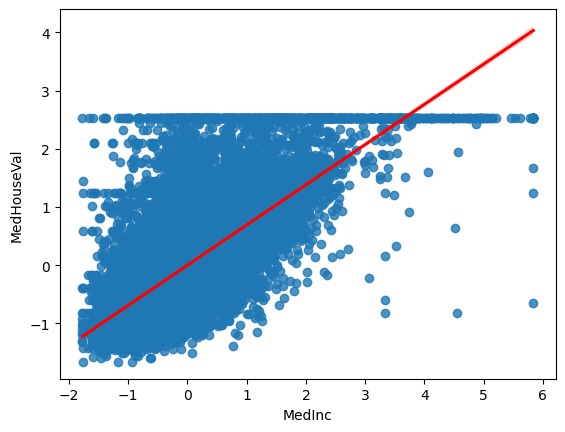

In [19]:
n_feature = 0
sns.regplot(x=x_train[:, n_feature].numpy(), y=y_train[:, 0].numpy(),  line_kws={"color": "red"})
plt.xlabel(feature_names[n_feature])
plt.ylabel("MedHouseVal");

There seems to be a clear relationship (i.e. positive correlation) between these two variables: the higher "MedInc", the higher "MedHouseVal". As you can see in this plot, we can fit a straight line to model or summarize this relationship. The model automatically got fitted when we used `seaborn`'s `regplot()`. This line offers an immediate visualization of the thing we are trying to learn here: the **slope** (the "tilting" factor of the line) and **offset** or **bias**  of this line (how "high" the point is that the line sets out from). These numbers correspond to the (single) coefficient and the (single) bias in this model.

Mathematically, the plotted line comes from a model that has learned a linear equation that maps the input feature to the output feature:

$\hat{y} = w \times x + b$

How could we now, practically, estimate the coefficient $w$ and bias $b$ ourselves? By training on our example data, and finding the values for $w$ and $b$ that give us the best results, i.e. predictions ($\hat{y}$) that are maximally close to the actual target $y$. That goes as follows. We start by building a model.

### How to build models in PyTorch?

To learn more about PyTorch, take a look at [this material](https://pytorch.org/tutorials/beginner/introyt.html).

`torch.nn.Module` is a PyTorch base class meant to encapsulate behaviors specific to PyTorch Models and their components. The general pattern to define a model class:


In [20]:
class NameYourModel(nn.Module):
  def __init__(self):
    super(NameYourModel, self).__init__()
    # add your layers here

  def forward(self, x):
    # x it what you feed to your model
    # define how your layers should be used
    return "return something"

This shows the fundamental structure of a PyTorch model: the __init__() method  defines layers and other components of a model, and the forward() method is where the computation gets done.

Next, we are ready to add our first layer to the network, which will be a linear layer. Crucially, here we tell PyTorch about the dimensionality or **shape** of our input and output features (1 for both cases). Linear layer connects every input variable to every output variable.

In [21]:
class LinearModel(nn.Module):
  def __init__(self, in_features=1, out_features=1):
    super(LinearModel, self).__init__()
    self.layer = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    return self.layer(x)


linear_model = LinearModel()
# we send our model to the local GPU
linear_model = linear_model.cuda()

Note that we can print the model, or any of its submodules, to learn about its structure.

In [22]:
print(linear_model)

LinearModel(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


In [23]:
for name, param in linear_model.named_parameters():
  print(name, param)

layer.weight Parameter containing:
tensor([[-0.9420]], device='cuda:0', requires_grad=True)
layer.bias Parameter containing:
tensor([-0.1962], device='cuda:0', requires_grad=True)


Let's define a simple function to extract weights from an univariate linear model:

In [24]:
import copy
def get_weights(model):
  w = model.layer.weight.detach().cpu().numpy()
  b = model.layer.bias.detach().cpu().numpy()
  return copy.deepcopy(w), copy.deepcopy(b)

get_weights(linear_model)

(array([[-0.9420415]], dtype=float32), array([-0.19620287], dtype=float32))

### Optimizer

The next thing we'll specify is an **optimizer**: this is the abstract object that will optimize our network. We'll say more about this in a minute, but it's good to know already that "SGD" stands for **stochastic gradient descent**. The argument `"lr"` stands for **learning rate**, which should also ring a bell already. It's a common practice to use a relatively tiny value here.

*   too high learning rate will make the learning jump over minimum
*   too low learning rate will either take too long to converge or get stuck in an undesirable local minimum

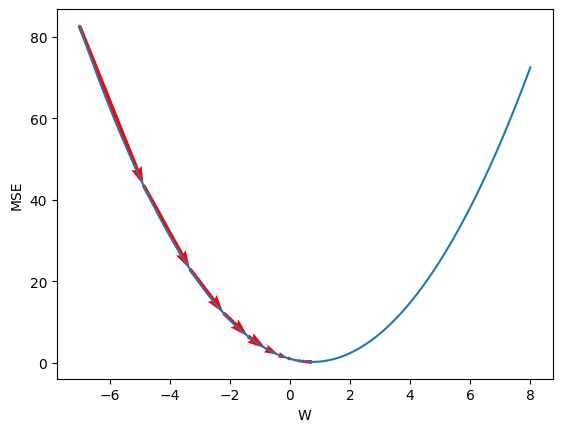

In [25]:
utils.plot_grad_descent(0.1, n_updates=17, x_scale=2)

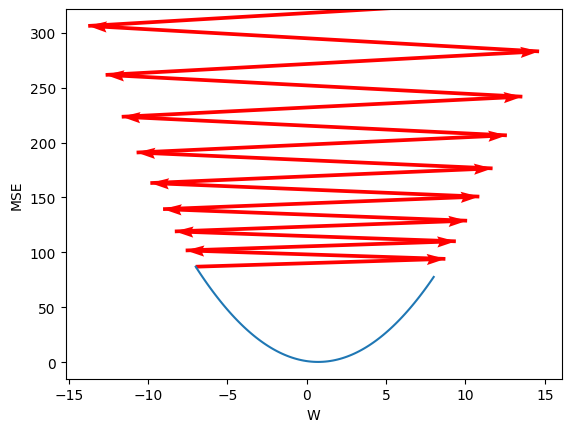

In [26]:
utils.plot_grad_descent(0.7, n_updates=17, x_scale=2)

Let's define PyTorch optimnizer:

In [27]:
sgd_optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

### Loss function

Below, we have to specify a **loss function** for our model. This is a function that primarily serves two purposes:

1. It allows us to monitor how well we are doing, since it estimates how far our current $\hat{y}$ (the network's predictions) is from the actual target $y$ (the "ground truth") for a particular dataset. Thus, it is a **measure of success**, which can function as an **evaluation measure** of training for a neural network.
2. It allows us to calculate the loss, which is needed to do the optimization of the network via gradient descent.

Our training **objective** is to **minimize** the loss over training. That why the loss function is also known as the **objective function**. Above, we used `"MSE"` or the **mean-squared error.** When working with a single scalar output, like in the example above, this is a very intuitive loss function. Let's define it for i-th instance:

$$ (\hat{y}_{i} - y_{i})^{2}  $$

We subtract the numbers from one another and take the square (so that we lose the "sign" of the difference). Finally, we take the average of these squared losses across all pairs ($\hat{y}_i$ vs $y_i$), to get a sense of how far our predictions were generally "off".

$$  \frac{1}{n} \sum_{i=1}^n  ( \hat{y}_i - y_{i})^{2} $$


Let's plot and define the loss function:


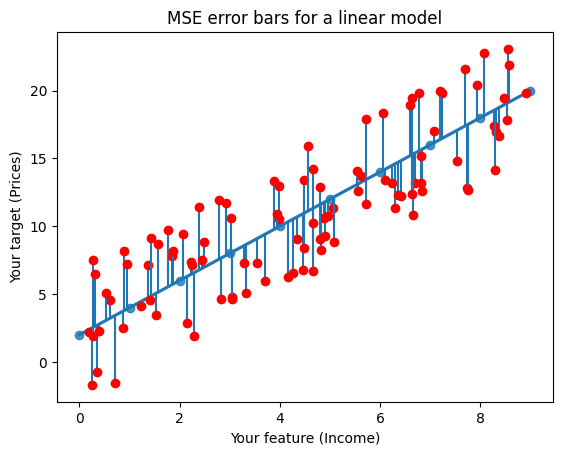

In [28]:
utils.plot_mse(100)

Let's define this function in PyTorch:

In [29]:
mse_loss = nn.MSELoss()

### Training

Finally, we need to define the training process. The training procedure is carried for a number of **epochs**. One "epoch" is one complete pass over the entire training data. Check `utils.py` for more details.
- Apparently, it is useful for us to iterate a couple of times over the data: at the end of each output the **loss** is being printed, which is a measure that indicates how far our $\hat{y}$ if from the actual $y$. Optimizing **loss** means **minimizing** it: this is exactly what we will see in the print statements. If it steadily goes down, it is good news.

In [30]:
train_dataset = torch.utils.data.TensorDataset(x_train[:, [n_feature]], y_train)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

dev_dataset = torch.utils.data.TensorDataset(x_dev[:, [n_feature]], y_dev)
dev_iter = torch.utils.data.DataLoader(dev_dataset, batch_size=len(dev_dataset), shuffle=False)

In [31]:
history = utils.train(model=linear_model,
                      loss=mse_loss,
                      optimizer=sgd_optimizer,
                      train_ds=train_iter,
                      dev_ds=dev_iter,
                      val_metrics = {"mse": nn.MSELoss()},
                      num_epochs=200, record_weights=get_weights)

epoch 1 train loss: 3.2272 val_mse: 3.0502
epoch 2 train loss: 3.1201 val_mse: 2.9494
epoch 3 train loss: 3.0172 val_mse: 2.8527
epoch 4 train loss: 2.9185 val_mse: 2.7598
epoch 5 train loss: 2.8236 val_mse: 2.6706
epoch 6 train loss: 2.7325 val_mse: 2.5849
epoch 7 train loss: 2.6450 val_mse: 2.5027
epoch 8 train loss: 2.5610 val_mse: 2.4237
epoch 9 train loss: 2.4803 val_mse: 2.3479
epoch 10 train loss: 2.4028 val_mse: 2.2751
epoch 11 train loss: 2.3283 val_mse: 2.2052
epoch 12 train loss: 2.2568 val_mse: 2.1380
epoch 13 train loss: 2.1882 val_mse: 2.0736
epoch 14 train loss: 2.1222 val_mse: 2.0117
epoch 15 train loss: 2.0589 val_mse: 1.9523
epoch 16 train loss: 1.9981 val_mse: 1.8953
epoch 17 train loss: 1.9397 val_mse: 1.8405
epoch 18 train loss: 1.8836 val_mse: 1.7879
epoch 19 train loss: 1.8297 val_mse: 1.7374
epoch 20 train loss: 1.7780 val_mse: 1.6890
epoch 21 train loss: 1.7283 val_mse: 1.6424
epoch 22 train loss: 1.6805 val_mse: 1.5977
epoch 23 train loss: 1.6347 val_mse: 1.55

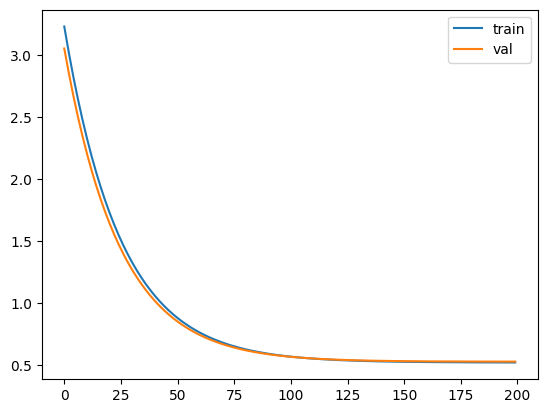

In [32]:
plt.plot(history['train_loss'], label="train")
plt.plot(history['val_mse'], label="val")
plt.legend()

Let us check now whether our network's parameters have changed. The coefficient  𝑤  and  𝑏  have been initialized in a fairly random fashion. Next on, every epoch the linear line gets closer to the final solution:

In [ ]:
plt.scatter(x_train[:,n_feature], y_train)
x = np.linspace(-2, 5, 100)

for epoch, params in enumerate(history["params"]):
  if epoch%20==0:
    w, b = params
    # we extract numbers from matrices
    y_pred = w*x + b
    plt.plot(x, y_pred.squeeze(), label=epoch)

plt.legend()

We indeed get a pretty neat trend line that approximates the that we obtained from `seaborn`'s `regplot()` above.

In [ ]:
sns.regplot(x=x_train[:, n_feature].numpy(), y=y_train[:, 0].numpy(),  line_kws={"color": "red"})
x = np.linspace(-2, 5, 100)
w, b = history['params'][-1]
y_pred = w*x + b
plt.plot(x, y_pred.squeeze(), c='black')

### Test

Let's finally conduct an evaluation of our model.

In [ ]:
test_dataset = torch.utils.data.TensorDataset(x_test[:, [n_feature]],
                                              torch.tensor(y_test.values, dtype=torch.float))
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
predictions = utils.test(linear_model, test_iter)

We need to inverse_transform the predictions of the model back to the unscaled target values to understand the real (unscaled) predictions.

In [ ]:
unscaled_predictions = y_scaler.inverse_transform(predictions)

Let's define absolute error for i-th instance:

$$ \mid\hat{y}_{i} - y_{i}\mid  $$

We subtract the numbers from one another and remove the "sign" of the difference. Finally, we take the average of these differences across all pairs ($\hat{y}_i$ vs $y_i$), to get a sense of how far our predictions were generally "off".

$$  \frac{1}{n} \sum_{i=1}^n  \mid \hat{y}_i - y_{i}\mid $$

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
mae(y_true=unscaled_predictions, y_pred=y_test)

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(y_true=unscaled_predictions, y_pred=y_test)

Let's plot our test predictions.

In [ ]:
sns.regplot(x=x_test[:, n_feature].numpy(), y=y_test,  line_kws={"color": "red"})
sns.regplot(x=x_test[:, n_feature].numpy(), y=unscaled_predictions,  line_kws={"color": "blue"})